In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

df = pd.read_excel("factory_process_CLA_raw.xlsx")
data = df.copy()

In [6]:
# Identifier les variables quantitatives (numériques)
numerical = data.select_dtypes(exclude="object").columns

# Identifier les variables qualitatives (catégorielles)
categorical = data.select_dtypes(include="object").columns

proportion = {}
for col in categorical:
    proportion[col] = data[col].value_counts(normalize=True)

proportion = pd.DataFrame(proportion)
df_melted = proportion.reset_index().melt(id_vars="index",
                                          var_name="Conformity",
                                          value_name="Proportion")
df_melted.rename(columns={"index": "Status"}, inplace=True)

# Stacked bar chart
fig = px.bar(df_melted,
             x="Conformity",
             y="Proportion",
             color="Status",
             barmode="stack",
             title="Conform vs Non-conform per Conformity Check")

fig.show()


In [8]:
# Nombre de valeurs manquantes par colonne
missing_counts = data[numerical].isnull().sum()
missing_percent = data[numerical].isnull().mean() * 100
print(pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing', 'Percent']))

                                                    Missing    Percent
Humidity                                                 81  10.012361
Temperature                                              81  10.012361
Machine1,RawMaterial,Property1                           81  10.012361
Machine1,RawMaterial,Property2                           81  10.012361
Machine1,RawMaterial,Property3                           81  10.012361
Machine1,RawMaterial,Property4                           81  10.012361
Machine1,RawMaterialFeederParameter,U,Actual             81  10.012361
Machine1,Zone1Temperature,C,Actual                       81  10.012361
Machine1,Zone2Temperature,C,Actual                       81  10.012361
Machine1,MotorAmperage,U,Actual                          81  10.012361
Machine1,MotorRPM,C,Actual                               81  10.012361
Machine1,MaterialPressure,U,Actual                       81  10.012361
Machine1,MaterialTemperature,U,Actual                    81  10.012361
Machin

la forme de la distribution : symétrique, asymétrique

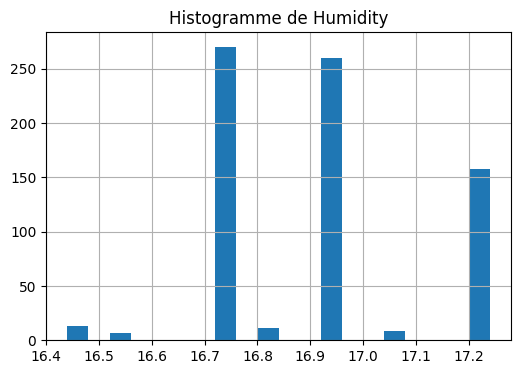

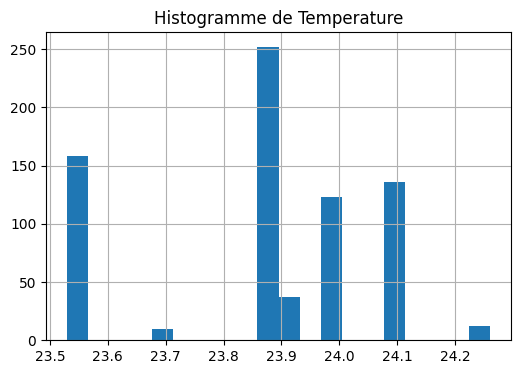

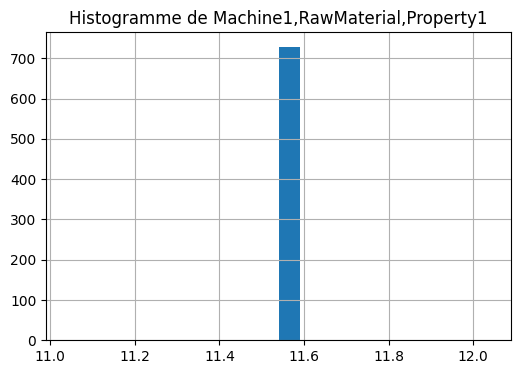

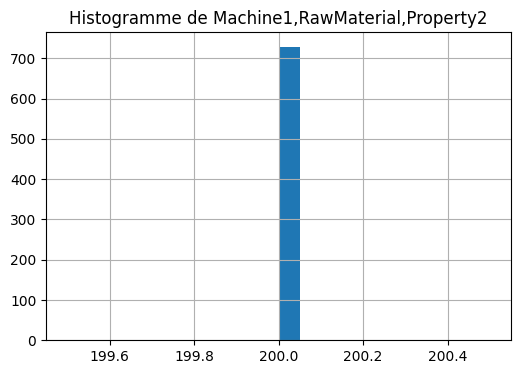

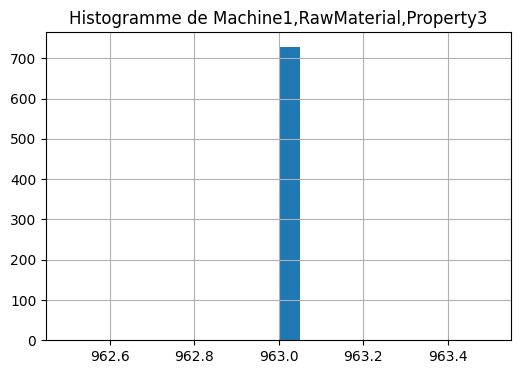

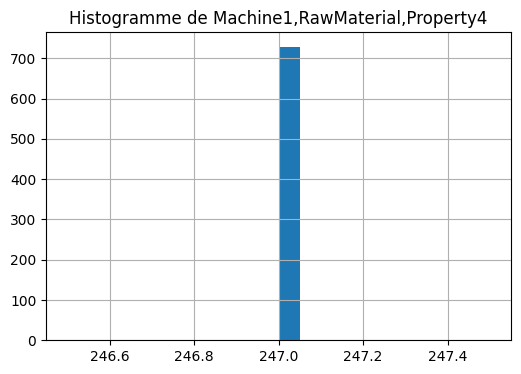

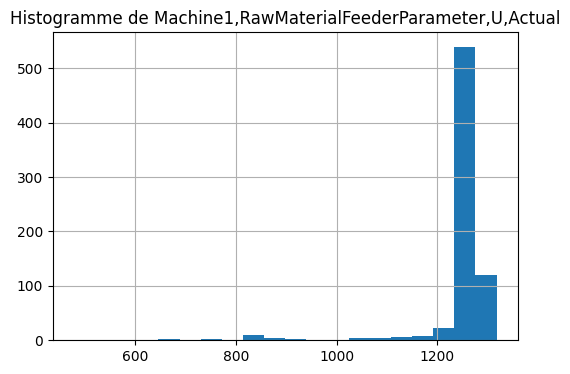

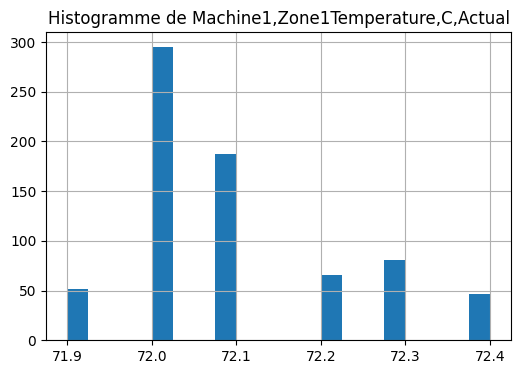

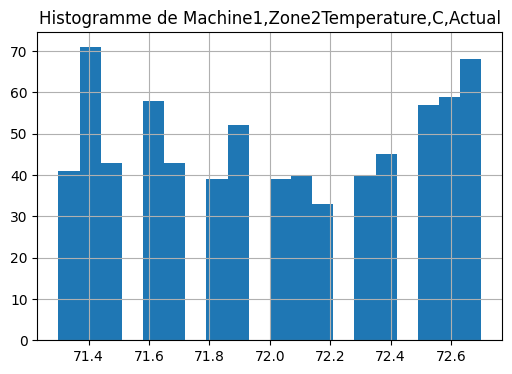

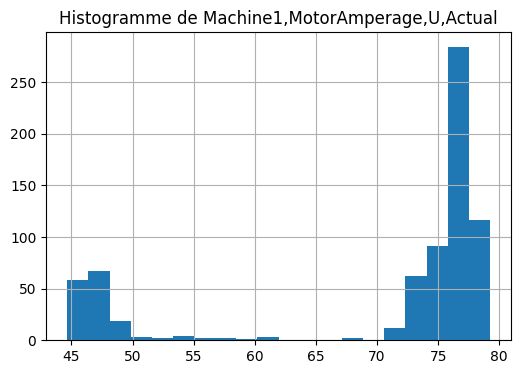

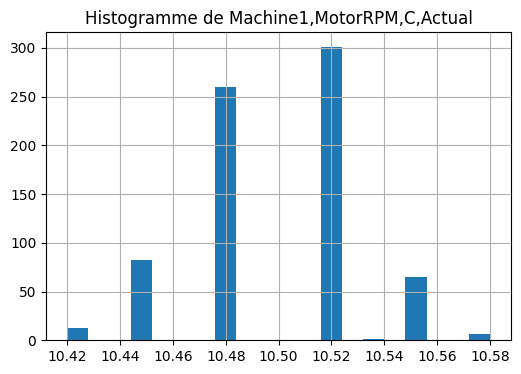

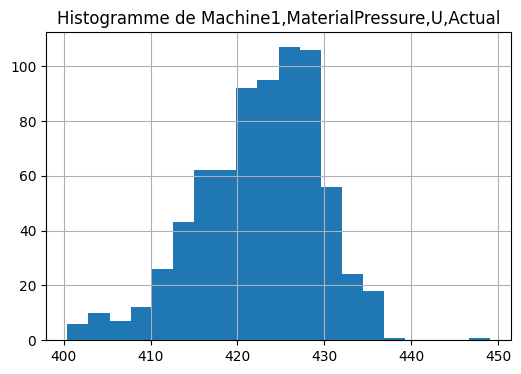

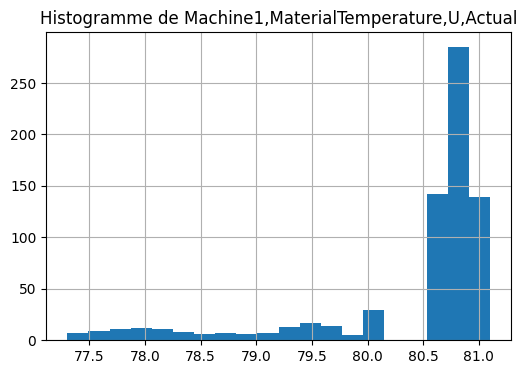

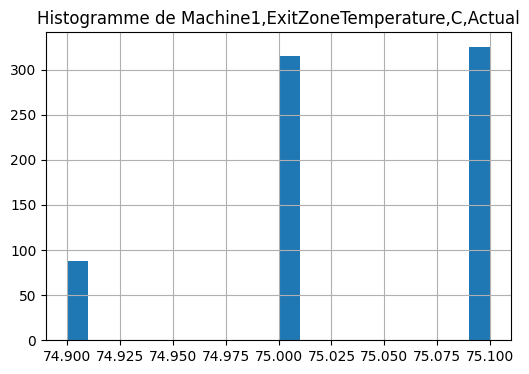

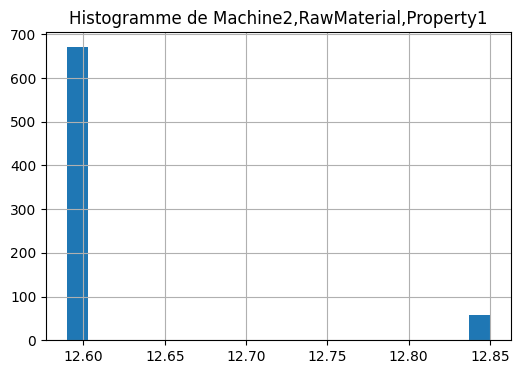

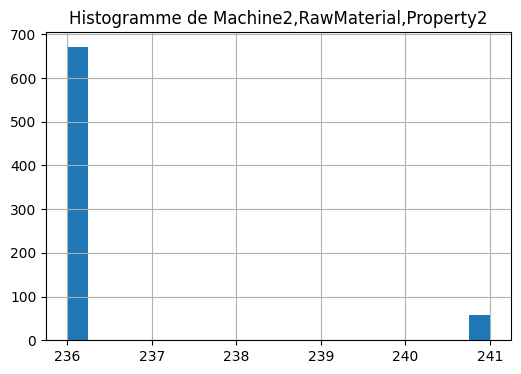

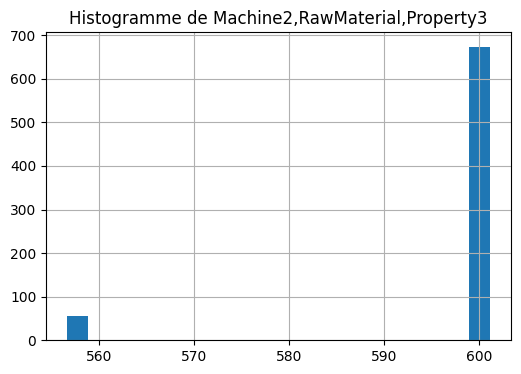

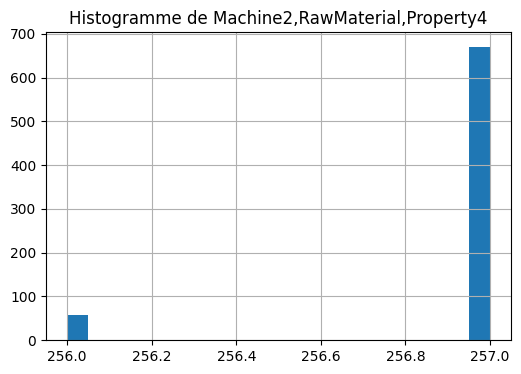

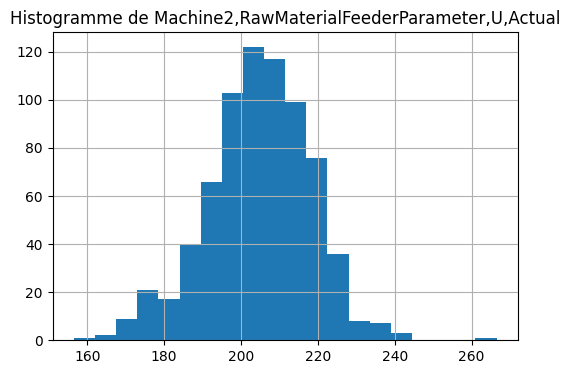

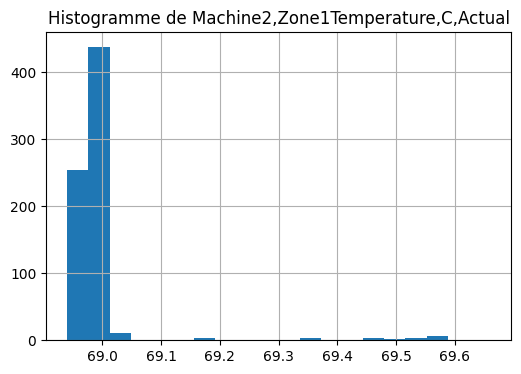

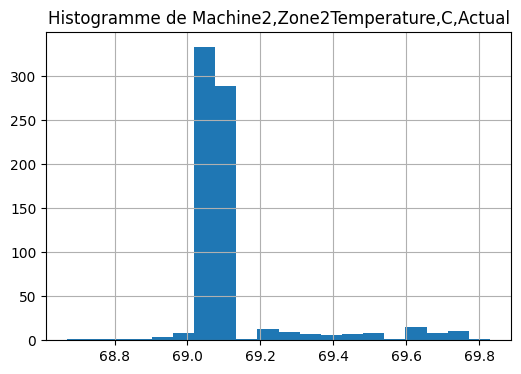

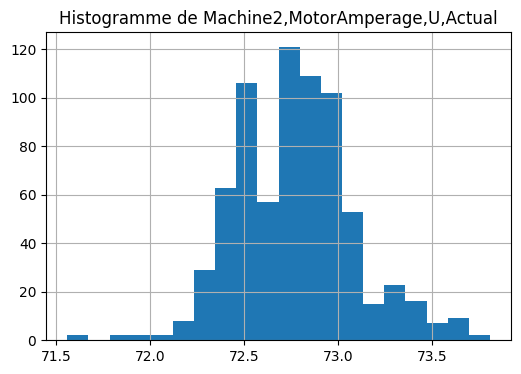

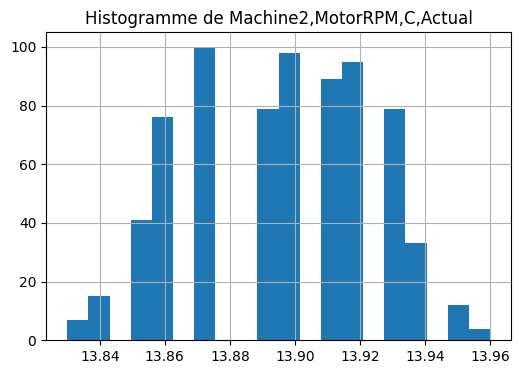

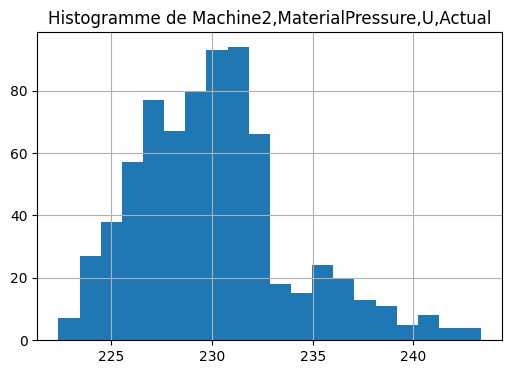

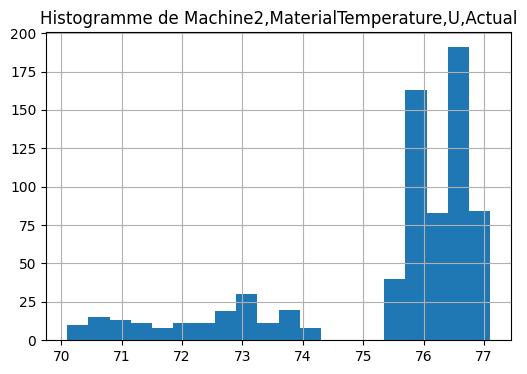

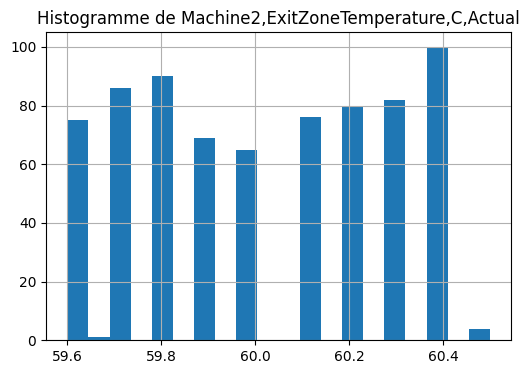

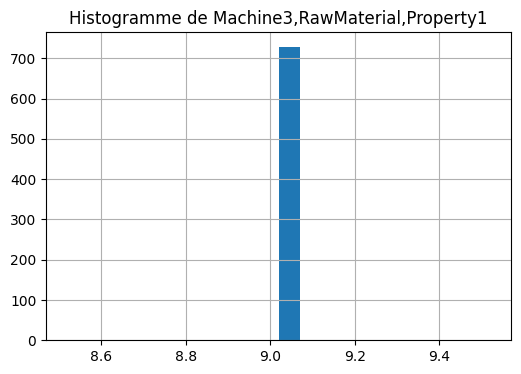

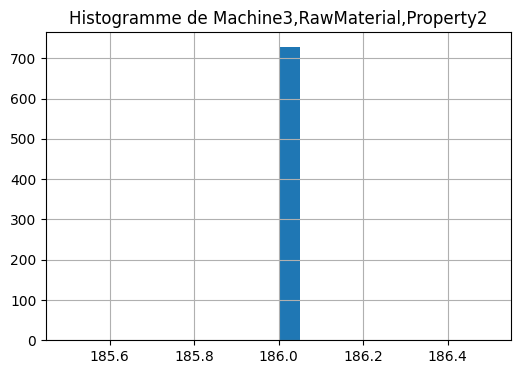

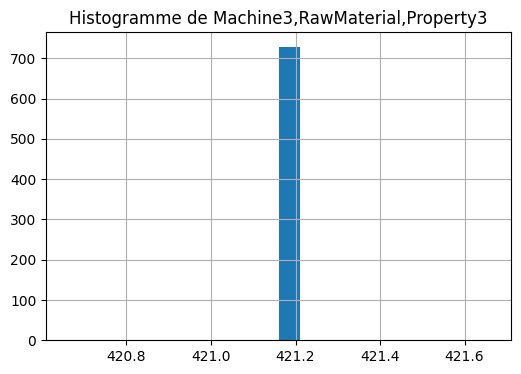

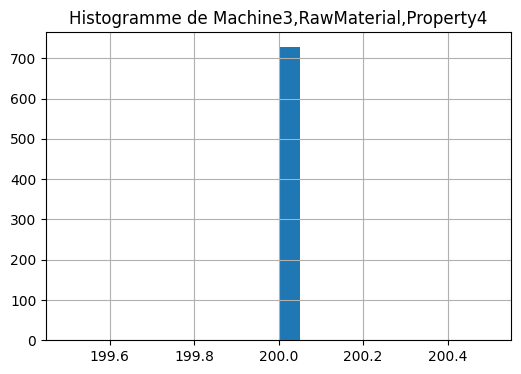

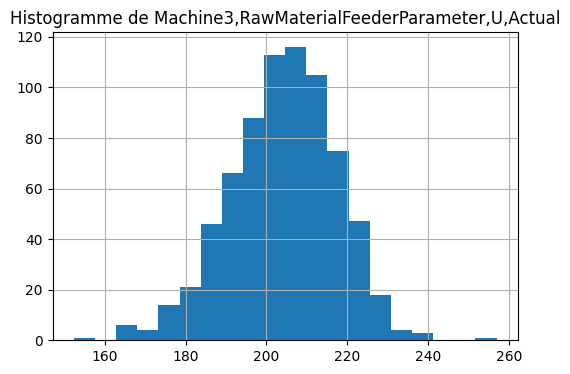

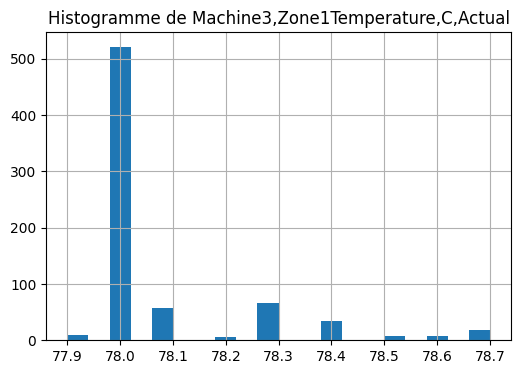

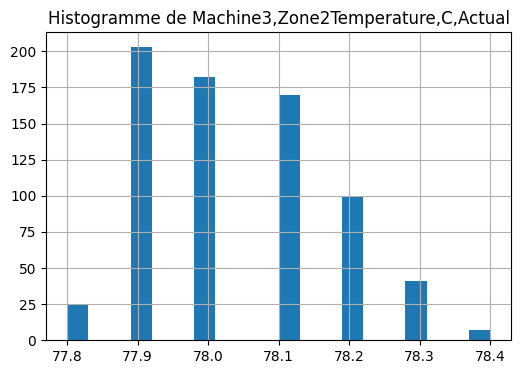

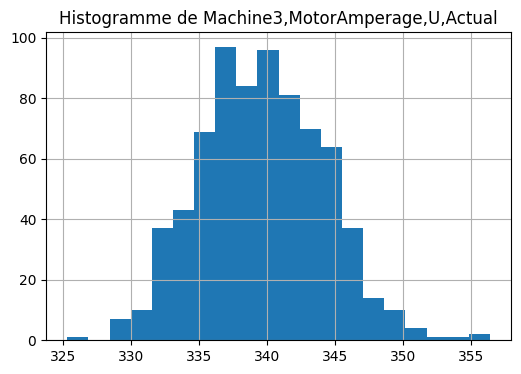

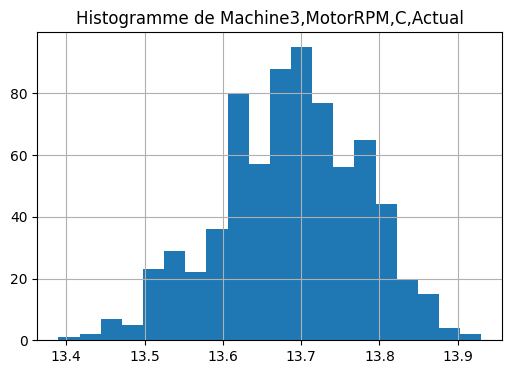

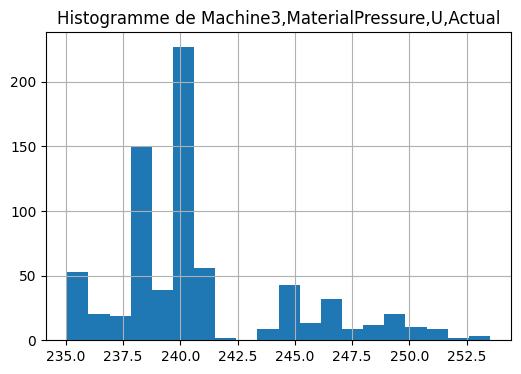

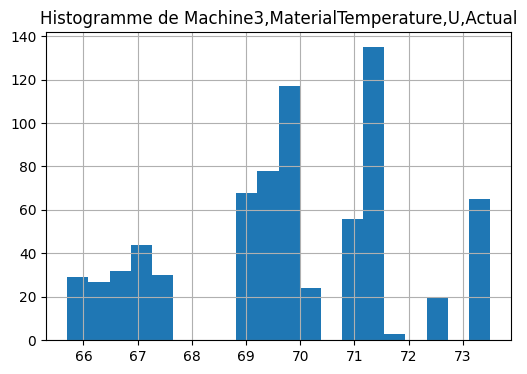

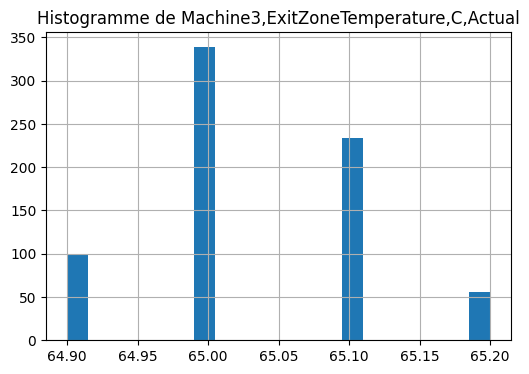

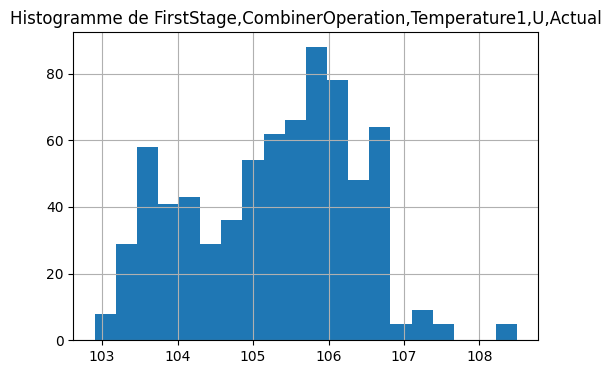

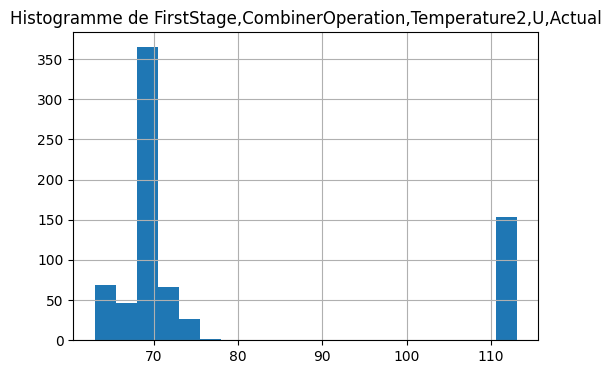

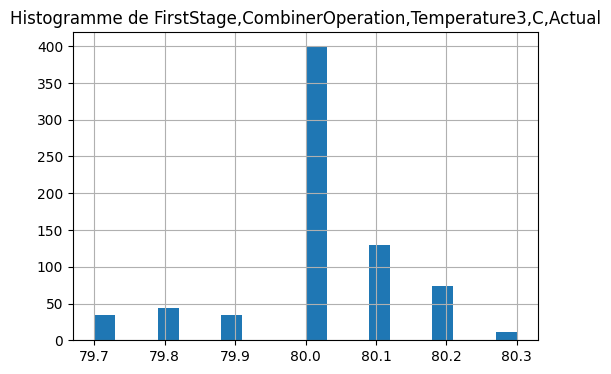

In [ ]:
for col in numerical:
    plt.figure(figsize=(6,4))
    data[col].hist(bins=20)
    plt.title(f'Histogramme de {col}')
    plt.show()


In [16]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# ---------------- CONFIG ----------------
# df should already exist in your environment
# numerical can be a pandas.Index or a list of column names
# Example to auto-get numerical:
# numerical = df.select_dtypes(include='number').columns
bw_method = None  # tweak bandwidth if needed, e.g. 0.3
# ----------------------------------------
df=data
numerical = list(numerical)  # make sure it's a simple list
if len(numerical) == 0:
    raise ValueError("`numerical` is empty — provide at least one numeric column name.")

# First pass: compute KDEs for non-constant columns to get a sensible global y-scale
kde_results = {}    # col -> (x_grid, y) for non-constant
constant_info = {}  # col -> (value, count) for constant cols

for col in numerical:
    vals = df[col].dropna().values
    if vals.size == 0:
        # empty column
        continue

    if np.allclose(vals, vals[0]):
        # constant column
        constant_info[col] = (float(vals[0]), int(vals.size))
    else:
        # compute KDE (safe fallback to histogram interp)
        try:
            kde = gaussian_kde(vals, bw_method=bw_method)
            lo, hi = vals.min(), vals.max()
            margin = (hi - lo) * 0.1 if hi > lo else 1.0
            x_grid = np.linspace(lo - margin, hi + margin, 400)
            y = kde(x_grid)
        except Exception:
            # fallback: density from histogram then interp
            lo, hi = vals.min(), vals.max()
            margin = (hi - lo) * 0.1 if hi > lo else 1.0
            x_grid = np.linspace(lo - margin, hi + margin, 400)
            hist, edges = np.histogram(vals, bins=50, density=True)
            bin_centers = (edges[:-1] + edges[1:]) / 2
            y = np.interp(x_grid, bin_centers, hist, left=0, right=0)

        kde_results[col] = (x_grid, y)

# determine a global ymax for plotting constant verticals (based on computed KDEs)
global_ymax = 0.0
for x, y in kde_results.values():
    if y.max() > global_ymax:
        global_ymax = float(y.max())

# if no non-constant columns exist, choose a default ymax
if global_ymax == 0:
    global_ymax = 1.0

# Build traces: KDEs for non-constant, vertical line + marker for constant
traces = []
for col in numerical:
    # empty column -> invisible empty trace
    vals = df[col].dropna().values
    if vals.size == 0:
        traces.append(
            go.Scatter(
                x=[None], y=[None], name=col, visible=False,
                hoverinfo='text', hovertext=f'{col}: no non-null values'
            )
        )
        continue

    if col in kde_results:
        x_grid, y = kde_results[col]
        traces.append(
            go.Scatter(
                x=x_grid,
                y=y,
                mode='lines',
                fill='tozeroy',
                name=col,
                visible=False,
                hovertemplate=f'{col}<br>x: %{{x:.5g}}<br>density: %{{y:.5g}}<extra></extra>'
            )
        )
    else:
        # constant column: draw vertical line and a marker at top with count
        v, cnt = constant_info[col]
        y_top = global_ymax * 0.9  # vertical spike height (90% of KDE max)
        traces.append(
            go.Scatter(
                x=[v, v],
                y=[0, y_top],
                mode='lines',
                line=dict(width=3, dash='dash'),
                name=col,
                visible=False,
                hovertemplate=f'{col}<br>Value: {v:.5g}<br>Count: {cnt}<extra></extra>'
            )
        )
        # marker + annotation point so hover shows a label and it looks visible in legend
        traces.append(
            go.Scatter(
                x=[v],
                y=[y_top],
                mode='markers+text',
                marker=dict(size=8),
                text=[f'n={cnt}'],
                textposition='top center',
                name=f'{col} (constant)',
                visible=False,
                hovertemplate=f'{col}<br>Value: {v:.5g}<br>Count: {cnt}<extra></extra>'
            )
        )

# Make the first non-empty trace visible (find first trace that's not empty None)
first_visible_idx = None
for i, t in enumerate(traces):
    if t.x is not None and not (len(t.x)==1 and t.x[0] is None):
        first_visible_idx = i
        break
if first_visible_idx is not None:
    traces[first_visible_idx].visible = True

# Build dropdown buttons. Note: for constant cols we added 2 traces (line+marker), so we must turn on both
buttons = []
# need mapping from col -> indices in traces to show when selected
col_to_trace_idxs = {}
i = 0
for col in numerical:
    vals = df[col].dropna().values
    if vals.size == 0:
        col_to_trace_idxs[col] = [i]
        i += 1
        continue
    if col in kde_results:
        col_to_trace_idxs[col] = [i]
        i += 1
    else:
        # constant column used two traces (line + marker)
        col_to_trace_idxs[col] = [i, i+1]
        i += 2

for col in numerical:
    visible = [False] * len(traces)
    for idx in col_to_trace_idxs.get(col, []):
        visible[idx] = True
    buttons.append(dict(
        label=col,
        method='update',
        args=[{'visible': visible},
              {'title': f'KDE / Reality: {col}',
               'yaxis': {'title': 'Density (or spike)'},
               'xaxis': {'title': col}}]
    ))

fig = go.Figure(data=traces)
fig.update_layout(
    title=f'KDE / Reality: {numerical[0]}',
    updatemenus=[dict(active=0, buttons=buttons, x=0.0, y=1.12, xanchor='left', yanchor='top')],
    margin=dict(t=100, b=50, l=50, r=20),
    xaxis=dict(title=numerical[0]),
    yaxis=dict(title='Density (or spike)'),
    height=520,
)

fig.show()


In [17]:
# Créer dictionnaire pour stocker la méthode choisie
impute_methods = {}

for col in numerical:
    col_skew = data[col].skew()
    # Calcul IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]

    # Choix de la méthode
    if abs(col_skew) < 0.5 and len(outliers) == 0:
        impute_methods[col] = 'mean'
    else:
        impute_methods[col] = 'median'

# Appliquer l’imputation
for col, method in impute_methods.items():
    imputer = SimpleImputer(strategy=method)
    data[[col]] = imputer.fit_transform(data[[col]])

print(impute_methods)

{'Humidity': 'mean', 'Temperature': 'median', 'Machine1,RawMaterial,Property1': 'mean', 'Machine1,RawMaterial,Property2': 'mean', 'Machine1,RawMaterial,Property3': 'mean', 'Machine1,RawMaterial,Property4': 'mean', 'Machine1,RawMaterialFeederParameter,U,Actual': 'median', 'Machine1,Zone1Temperature,C,Actual': 'median', 'Machine1,Zone2Temperature,C,Actual': 'mean', 'Machine1,MotorAmperage,U,Actual': 'median', 'Machine1,MotorRPM,C,Actual': 'median', 'Machine1,MaterialPressure,U,Actual': 'median', 'Machine1,MaterialTemperature,U,Actual': 'median', 'Machine1,ExitZoneTemperature,C,Actual': 'median', 'Machine2,RawMaterial,Property1': 'median', 'Machine2,RawMaterial,Property2': 'median', 'Machine2,RawMaterial,Property3': 'median', 'Machine2,RawMaterial,Property4': 'median', 'Machine2,RawMaterialFeederParameter,U,Actual': 'median', 'Machine2,Zone1Temperature,C,Actual': 'median', 'Machine2,Zone2Temperature,C,Actual': 'median', 'Machine2,MotorAmperage,U,Actual': 'median', 'Machine2,MotorRPM,C,Act

In [19]:
data[categorical] = data[categorical].replace({"Conform":1, "Non-conform":0})
data

/tmp/ipython-input-34750449.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Humidity,Temperature,"Machine1,RawMaterial,Property1","Machine1,RawMaterial,Property2","Machine1,RawMaterial,Property3","Machine1,RawMaterial,Property4","Machine1,RawMaterialFeederParameter,U,Actual","Machine1,Zone1Temperature,C,Actual","Machine1,Zone2Temperature,C,Actual","Machine1,MotorAmperage,U,Actual",...,Conformity3,Conformity4,Conformity5,Conformity6,Conformity7,Conformity8,Conformity9,Conformity10,Conformity11,Conformity12
0,17.24,23.53,11.54,200.0,963.0,247.0,1262.58,72.3,72.700000,49.37,...,1,1,1,0,1,1,0,0,1,1
1,17.24,23.53,11.54,200.0,963.0,247.0,1134.89,72.3,72.700000,48.84,...,1,1,1,0,1,1,0,0,1,1
2,17.24,23.53,11.54,200.0,963.0,247.0,1262.58,72.3,72.700000,76.15,...,1,1,1,0,1,1,0,0,1,1
3,17.24,23.86,11.54,200.0,963.0,247.0,1246.37,72.1,72.700000,48.70,...,1,1,1,0,1,1,1,0,1,1
4,17.24,23.53,11.54,200.0,963.0,247.0,1247.26,72.1,72.700000,49.10,...,1,1,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,16.73,24.09,11.54,200.0,963.0,247.0,1262.58,72.0,72.300000,73.05,...,1,0,1,0,1,1,1,1,1,1
805,16.73,24.09,11.54,200.0,963.0,247.0,1262.58,72.0,72.300000,73.05,...,1,0,1,0,1,1,1,1,1,1
806,16.73,24.09,11.54,200.0,963.0,247.0,1257.27,72.0,72.300000,72.78,...,1,0,1,0,1,1,1,1,1,1
807,16.73,24.09,11.54,200.0,963.0,247.0,1262.36,72.1,72.014045,76.15,...,1,0,1,0,1,1,1,1,1,1


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 53 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Humidity                                            809 non-null    float64
 1   Temperature                                         809 non-null    float64
 2   Machine1,RawMaterial,Property1                      809 non-null    float64
 3   Machine1,RawMaterial,Property2                      809 non-null    float64
 4   Machine1,RawMaterial,Property3                      809 non-null    float64
 5   Machine1,RawMaterial,Property4                      809 non-null    float64
 6   Machine1,RawMaterialFeederParameter,U,Actual        809 non-null    float64
 7   Machine1,Zone1Temperature,C,Actual                  809 non-null    float64
 8   Machine1,Zone2Temperature,C,Actual                  809 non-null    float64
 9  

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialiser le StandardScaler
scaler = StandardScaler()

# Ajuster et transformer les données
data_scaled = scaler.fit_transform(data[numerical])

data[numerical] = data_scaled
data

,Humidity,Temperature,"Machine1,RawMaterial,Property1","Machine1,RawMaterial,Property2","Machine1,RawMaterial,Property3","Machine1,RawMaterial,Property4","Machine1,RawMaterialFeederParameter,U,Actual","Machine1,Zone1Temperature,C,Actual","Machine1,Zone2Temperature,C,Actual","Machine1,MotorAmperage,U,Actual",...,Conformity3,Conformity4,Conformity5,Conformity6,Conformity7,Conformity8,Conformity9,Conformity10,Conformity11,Conformity12
0,1.663702,-1.750430,3.552714e-15,0.0,0.0,0.0,0.205563,1.597860,1.578266e+00,-1.835640,...,1,1,1,0,1,1,0,0,1,1
1,1.663702,-1.750430,3.552714e-15,0.0,0.0,0.0,-1.270109,1.597860,1.578266e+00,-1.881531,...,1,1,1,0,1,1,0,0,1,1
2,1.663702,-1.750430,3.552714e-15,0.0,0.0,0.0,0.205563,1.597860,1.578266e+00,0.483153,...,1,1,1,0,1,1,0,0,1,1
3,1.663702,-0.013339,3.552714e-15,0.0,0.0,0.0,0.018229,0.029087,1.578266e+00,-1.893654,...,1,1,1,0,1,1,1,0,1,1
4,1.663702,-1.750430,3.552714e-15,0.0,0.0,0.0,0.028515,0.029087,1.578266e+00,-1.859019,...,1,1,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,-0.968053,1.197362,3.552714e-15,0.0,0.0,0.0,0.205563,-0.755299,6.579343e-01,0.214734,...,1,0,1,0,1,1,1,1,1,1
805,-0.968053,1.197362,3.552714e-15,0.0,0.0,0.0,0.205563,-0.755299,6.579343e-01,0.214734,...,1,0,1,0,1,1,1,1,1,1
806,-0.968053,1.197362,3.552714e-15,0.0,0.0,0.0,0.144197,-0.755299,6.579343e-01,0.191356,...,1,0,1,0,1,1,1,1,1,1
807,-0.968053,1.197362,3.552714e-15,0.0,0.0,0.0,0.203021,0.029087,-3.269676e-14,0.483153,...,1,0,1,0,1,1,1,1,1,1


In [22]:
import plotly.express as px

fig = px.imshow(data[numerical].corr(), width=1500, height=1500, text_auto=True, color_continuous_scale="RdYlGn")
fig.show()


In [26]:
# seuil de corrélation
seuil = 0.7

# suppression des colonnes constantes
const_cols = [col for col in numerical if data[col].var() == 0]

# matrice de corrélation
M_corr = data[numerical].corr().abs()

# on met la diagonale à 0 pour ignorer la corrélation avec soi-même
np.fill_diagonal(M_corr.values, 0)

# colonnes à supprimer
colonnes_supprimer = set(const_cols)

# liste des colonnes à traiter
cols = set(numerical) - set(const_cols)

while cols:
    cols_list = list(cols)  # <-- important : convert set en list pour pandas
    # compter combien de corrélations > seuil pour chaque colonne
    corr_count = (M_corr.loc[cols_list, cols_list] > seuil).sum()
    # trouver la colonne la plus corrélée
    if corr_count.max() == 0:
        break
    col_to_remove = corr_count.idxmax()
    colonnes_supprimer.add(col_to_remove)
    cols.remove(col_to_remove)

# DataFrame filtré
data_filtre = data.drop(columns=colonnes_supprimer)

# mise à jour de la liste numerical
numerical = [col for col in numerical if col not in colonnes_supprimer]

print(f"Colonnes supprimées ({len(colonnes_supprimer)}):", colonnes_supprimer)
data_filtre

Colonnes supprimées (18): {'Machine2,RawMaterial,Property1', 'Machine3,MaterialPressure,U,Actual', 'Conformity2', 'Machine1,RawMaterial,Property1', 'Machine2,RawMaterial,Property2', 'Humidity', 'Machine1,RawMaterial,Property3', 'Machine1,RawMaterial,Property4', 'Machine3,RawMaterial,Property4', 'Machine1,MotorAmperage,U,Actual', 'Machine2,MaterialTemperature,U,Actual', 'Machine3,RawMaterial,Property2', 'Machine2,RawMaterial,Property4', 'Machine3,MaterialTemperature,U,Actual', 'Temperature', 'Conformity5', 'Machine1,MaterialTemperature,U,Actual', 'Machine1,RawMaterial,Property2'}


,"Machine1,RawMaterialFeederParameter,U,Actual","Machine1,Zone1Temperature,C,Actual","Machine1,Zone2Temperature,C,Actual","Machine1,MotorRPM,C,Actual","Machine1,MaterialPressure,U,Actual","Machine1,ExitZoneTemperature,C,Actual","Machine2,RawMaterial,Property3","Machine2,RawMaterialFeederParameter,U,Actual","Machine2,Zone1Temperature,C,Actual","Machine2,Zone2Temperature,C,Actual",...,Conformity1,Conformity3,Conformity4,Conformity6,Conformity7,Conformity8,Conformity9,Conformity10,Conformity11,Conformity12
0,0.205563,1.597860,1.578266e+00,0.615365,1.267260,1.084961,0.270082,0.929838,0.158731,4.911201,...,0,1,1,0,1,1,0,0,1,1
1,-1.270109,1.597860,1.578266e+00,0.615365,0.784353,1.084961,0.270082,0.028228,-0.202414,3.949355,...,0,1,1,0,1,1,0,0,1,1
2,0.205563,1.597860,1.578266e+00,-0.702106,1.659338,1.084961,0.270082,-0.446487,-0.202414,4.155465,...,0,1,1,0,1,1,0,0,1,1
3,0.018229,0.029087,1.578266e+00,-1.690209,1.221845,1.084961,0.270082,-0.821283,-0.322796,4.155465,...,0,1,1,0,1,1,1,0,1,1
4,0.028515,0.029087,1.578266e+00,0.615365,2.502534,1.084961,0.270082,1.980355,-0.322796,4.086762,...,0,1,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.205563,-0.755299,6.579343e-01,0.615365,-1.875422,-0.449538,0.270082,0.639021,0.158731,-0.241542,...,1,1,0,0,1,1,1,1,1,1
805,0.205563,-0.755299,6.579343e-01,-0.702106,-0.690104,-0.449538,-3.702579,1.288304,0.038349,-0.172839,...,1,1,0,0,1,1,1,1,1,1
806,0.144197,-0.755299,6.579343e-01,-0.702106,-1.851201,-0.449538,0.270082,0.028228,0.038349,-0.241542,...,1,1,0,0,1,1,1,1,1,1
807,0.203021,0.029087,-3.269676e-14,0.615365,-0.989840,-0.449538,-3.702579,0.492835,0.158731,-0.172839,...,1,1,0,0,1,1,1,1,1,1


In [11]:
from scipy.stats import chi2_contingency

to_drop = set()
seuil = 0.95
categorical = [col for col in categorical if data[col].value_counts(normalize=True).max() <= seuil]
print("Colonnes catégorielles conservées (moins de 95% d'une même modalité) :", categorical)
pval_matrix = pd.DataFrame(index=categorical, columns=categorical)

# Boucle sur chaque paire de colonnes
for i in range(len(categorical)):
    for j in range(i + 1, len(categorical)):
        col1 = categorical[i]
        col2 = categorical[j]

        # Tableau de contingence
        contingency = pd.crosstab(data[col1], data[col2])

        # Test Khi²
        chi2, p, dof, expected = chi2_contingency(contingency)

        pval_matrix.loc[col1, col2] = p

        # Si l’une des colonnes a déjà été supprimée, ignorer
        if col1 in to_drop or col2 in to_drop:
            continue

        # Si dépendance significative, supprimer col2
        if p < 0.05:
            # Calculer la variance de chaque colonne
            var1 = data[col1].var()
            var2 = data[col2].var()

            # Supprimer la colonne avec la plus petite variance
            if var1 >= var2:
                to_drop.add(col2)
            else:
                to_drop.add(col1)

# Supprimer les colonnes supprimées de la liste numerical
categorical = [col for col in categorical if col not in to_drop]

# Créer un nouveau DataFrame filtré

col = list(numerical) + list(categorical)
data_filtre = data_filtre[col]

# Affichage des résultats
print("Colonnes filtrée indépendantes :", categorical)

# Convertir en float
pval_matrix = pval_matrix.astype(float)

# Heatmap interactive avec Plotly
fig = px.imshow(pval_matrix, width=800, height=800, text_auto=".2f", color_continuous_scale=["red", "yellow", "green"], title="Dépendance entre variables catégorielles (p-values Khi²)")


fig.update_layout(xaxis_title="Variables", yaxis_title="Variables")
fig.show()

data_filtre


Colonnes catégorielles conservées (moins de 95% d'une même modalité) : ['Conformity1 ', 'Conformity2', 'Conformity4', 'Conformity9', 'Conformity10']
Colonnes filtrée indépendantes : ['Conformity2', 'Conformity4']


,"Machine1,RawMaterialFeederParameter,U,Actual","Machine1,Zone1Temperature,C,Actual","Machine1,Zone2Temperature,C,Actual","Machine1,MotorRPM,C,Actual","Machine1,MaterialPressure,U,Actual","Machine1,ExitZoneTemperature,C,Actual","Machine2,RawMaterial,Property1","Machine2,RawMaterialFeederParameter,U,Actual","Machine2,Zone1Temperature,C,Actual","Machine2,Zone2Temperature,C,Actual",...,"Machine3,RawMaterialFeederParameter,U,Actual","Machine3,Zone2Temperature,C,Actual","Machine3,MotorAmperage,U,Actual","Machine3,MotorRPM,C,Actual","Machine3,ExitZoneTemperature,C,Actual","FirstStage,CombinerOperation,Temperature1,U,Actual","FirstStage,CombinerOperation,Temperature2,U,Actual","FirstStage,CombinerOperation,Temperature3,C,Actual",Conformity2,Conformity4
0,0.205563,1.597860,1.578266e+00,0.615365,1.267260,1.084961,-0.275314,0.929838,0.158731,4.911201,...,-0.086493,2.133985,2.562095,1.082565,8.639077e-01,-2.084223,2.029671,-0.089325,1,1
1,-1.270109,1.597860,1.578266e+00,0.615365,0.784353,1.084961,-0.275314,0.028228,-0.202414,3.949355,...,2.393690,2.133985,0.692710,0.040252,-1.858120e-13,-2.084223,2.000160,-0.089325,1,1
2,0.205563,1.597860,1.578266e+00,-0.702106,1.659338,1.084961,-0.275314,-0.446487,-0.202414,4.155465,...,0.838415,2.133985,-1.227956,-1.812750,8.639077e-01,-2.084223,2.023769,-0.089325,1,1
3,0.018229,0.029087,1.578266e+00,-1.690209,1.221845,1.084961,-0.275314,-0.821283,-0.322796,4.155465,...,-0.789899,-0.264943,1.268443,-0.770437,8.639077e-01,-1.795534,2.041476,-0.089325,1,1
4,0.028515,0.029087,1.578266e+00,0.615365,2.502534,1.084961,-0.275314,1.980355,-0.322796,4.086762,...,-0.604124,2.133985,0.415332,-2.507626,8.639077e-01,-1.795534,2.029671,-0.089325,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.205563,-0.755299,6.579343e-01,0.615365,-1.875422,-0.449538,3.632215,0.639021,0.158731,-0.241542,...,-2.318975,0.534700,-0.661546,0.735127,-4.436278e-01,-1.506844,-0.809306,-0.089325,1,0
805,0.205563,-0.755299,6.579343e-01,-0.702106,-0.690104,-0.449538,3.632215,1.288304,0.038349,-0.172839,...,-0.825625,0.534700,-1.190661,-2.160188,-4.436278e-01,-1.506844,-0.791599,-0.089325,1,0
806,0.144197,-0.755299,6.579343e-01,-0.702106,-1.851201,-0.449538,3.632215,0.028228,0.038349,-0.241542,...,-1.475840,0.534700,-0.862004,0.156064,-4.436278e-01,-1.506844,-0.815208,-0.089325,1,0
807,0.203021,0.029087,-3.269676e-14,0.615365,-0.989840,-0.449538,3.632215,0.492835,0.158731,-0.172839,...,-0.747028,0.534700,-1.057800,-0.075561,-4.436278e-01,-1.603074,-0.797501,-0.089325,1,0


In [12]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_scores = pd.DataFrame(index=numerical, columns=categorical)

for col_target in categorical:
    y = data_filtre[col_target]
    X = data_filtre[numerical]

    # Calcul de l'information mutuelle
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)

    mutual_info_scores[col_target] = mi

# Afficher les scores
mutual_info_scores = mutual_info_scores.astype(float)
print(mutual_info_scores.sort_values(by=categorical[0], ascending=False))

fig = px.bar(mutual_info_scores.reset_index().melt(id_vars='index'),width=1200, height=600, x='index', y='value', color='variable', barmode='group', title="Information Mutuelle entre variables quantitatives et cibles qualitatives")
fig.show()


                                                    Conformity2  Conformity4
FirstStage,CombinerOperation,Temperature2,U,Actual     0.523356     0.044409
FirstStage,CombinerOperation,Temperature1,U,Actual     0.491537     0.062023
Machine1,MaterialPressure,U,Actual                     0.188625     0.026375
Machine1,RawMaterialFeederParameter,U,Actual           0.177264     0.007707
Machine1,Zone1Temperature,C,Actual                     0.153462     0.038039
Machine2,MotorAmperage,U,Actual                        0.113294     0.023704
Machine3,ExitZoneTemperature,C,Actual                  0.105320     0.025197
Machine2,Zone2Temperature,C,Actual                     0.097823     0.000000
Machine1,ExitZoneTemperature,C,Actual                  0.089340     0.025159
Machine2,RawMaterialFeederParameter,U,Actual           0.076690     0.004161
Machine2,RawMaterial,Property1                         0.076534     0.023356
FirstStage,CombinerOperation,Temperature3,C,Actual     0.074463     0.019087